In [33]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import folium # plotting library
from folium import plugins

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns


import os
for dirname, _, filenames in os.walk('dataset/updated_final_dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


dataset/updated_final_dataset/._SUCCESS.crc
dataset/updated_final_dataset/.part-00000-aa676cdb-8c51-4d6d-bf5c-769e9b44f214-c000.csv.crc
dataset/updated_final_dataset/_SUCCESS
dataset/updated_final_dataset/part-00000-aa676cdb-8c51-4d6d-bf5c-769e9b44f214-c000.csv


In [34]:
df = pd.read_csv('dataset/updated_final_dataset/part-00000-aa676cdb-8c51-4d6d-bf5c-769e9b44f214-c000.csv')

df.head()

,StartTime(UTC),EndTime(UTC),Severity,Precipitation(in),AirportCode,LocationLat,LocationLng,City,State,Broad_Weather_Condition
0,2022-12-31T23:55:00.000-06:00,2022-12-31T23:56:00.000-06:00,Light,0.01,KGTB,44.0556,-75.7195,Fort Drum,NY,rainy
1,2022-12-31T23:44:00.000-06:00,2022-12-31T23:56:00.000-06:00,Light,0.00,KSLI,33.7963,-118.0418,Los Alamitos,CA,rainy
2,2022-12-31T23:44:00.000-06:00,2022-12-31T23:56:00.000-06:00,Heavy,0.95,KAKQ,36.9827,-77.0014,Wakefield,VA,rainy
3,2022-12-31T23:43:00.000-06:00,2022-12-31T23:59:00.000-06:00,Moderate,0.22,KSJC,37.3594,-121.9244,San Jose,CA,rainy
4,2022-12-31T23:43:00.000-06:00,2022-12-31T23:54:00.000-06:00,Light,0.02,KBWI,39.1733,-76.6840,Baltimore,MD,rainy


In [35]:
df['Broad_Weather_Condition'].value_counts()

Broad_Weather_Condition
rainy    10000
snowy    10000
cold     10000
foggy    10000
hail      2921
Name: count, dtype: int64

In [36]:
df['Severity'].value_counts()

Severity
Light       17135
Severe      17104
Moderate     5219
Other        2921
Heavy         542
Name: count, dtype: int64

In [37]:
df = df[(df['Severity'] != 'UNK') & (df['Severity'] != 'Other')]

df.head()

,StartTime(UTC),EndTime(UTC),Severity,Precipitation(in),AirportCode,LocationLat,LocationLng,City,State,Broad_Weather_Condition
0,2022-12-31T23:55:00.000-06:00,2022-12-31T23:56:00.000-06:00,Light,0.01,KGTB,44.0556,-75.7195,Fort Drum,NY,rainy
1,2022-12-31T23:44:00.000-06:00,2022-12-31T23:56:00.000-06:00,Light,0.00,KSLI,33.7963,-118.0418,Los Alamitos,CA,rainy
2,2022-12-31T23:44:00.000-06:00,2022-12-31T23:56:00.000-06:00,Heavy,0.95,KAKQ,36.9827,-77.0014,Wakefield,VA,rainy
3,2022-12-31T23:43:00.000-06:00,2022-12-31T23:59:00.000-06:00,Moderate,0.22,KSJC,37.3594,-121.9244,San Jose,CA,rainy
4,2022-12-31T23:43:00.000-06:00,2022-12-31T23:54:00.000-06:00,Light,0.02,KBWI,39.1733,-76.6840,Baltimore,MD,rainy


In [38]:
df_types = df[['AirportCode','Severity','Broad_Weather_Condition']]

df_types.head()

,AirportCode,Severity,Broad_Weather_Condition
0,KGTB,Light,rainy
1,KSLI,Light,rainy
2,KAKQ,Heavy,rainy
3,KSJC,Moderate,rainy
4,KBWI,Light,rainy


In [51]:
types = pd.get_dummies(df_types[['Broad_Weather_Condition']])

types['AirportCode'] = df_types['AirportCode']

# 按 AirportCode 進行聚合
types = types.groupby('AirportCode').sum().reset_index()

# 假設 weather_data 包含 AirportCode, LocationLat 和 LocationLng
location_data = df[['AirportCode', 'LocationLat', 'LocationLng']].drop_duplicates()

# 合併 types 和 location_data
combined_df = types.merge(location_data, on='AirportCode', how='left')

# 顯示結果
print(combined_df.head(10))



  AirportCode  Broad_Weather_Condition_cold  Broad_Weather_Condition_foggy  \
0        K01M                             2                              0   
1        K04V                             1                              0   
2        K04W                            10                              1   
3        K06D                            13                             17   
4        K08D                            10                             12   
5        K0A9                             4                             18   
6        K0CO                             3                              1   
7        K0E0                             0                              0   
8        K0F2                             3                              0   
9        K0J4                             1                              3   

   Broad_Weather_Condition_rainy  Broad_Weather_Condition_snowy  LocationLat  \
0                              3                             

In [52]:
codes = types[['AirportCode']]
types.drop('AirportCode', axis=1, inplace=True)

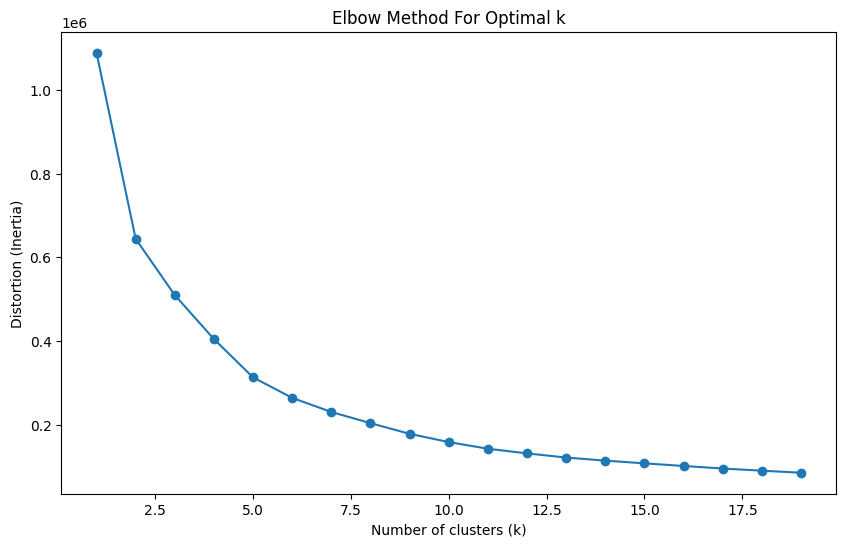

In [53]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def calculate_distortions(data, k_range=(1, 20), random_state=0, n_init=50, max_iter=500):
    distortions = []
    K = range(k_range[0], k_range[1])
    
    for k in K:
        kmean = KMeans(n_clusters=k, random_state=random_state, n_init=n_init, max_iter=max_iter)
        kmean.fit(data)
        distortions.append(kmean.inertia_)
    
    return K, distortions

def plot_elbow(K, distortions):
    plt.figure(figsize=(10, 6))
    plt.plot(K, distortions, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Distortion (Inertia)')
    plt.title('Elbow Method For Optimal k')
    plt.show()

# Example usage
K, distortions = calculate_distortions(types, k_range=(1, 20))
plot_elbow(K, distortions)



In [54]:
from sklearn.cluster import KMeans

# 假設 'types' 是用於聚類的特徵數據
kmeans = KMeans(n_clusters=5, random_state=0).fit(types)

# 使用 .loc 進行賦值以避免 SettingWithCopyWarning
codes.loc[:, 'cluster'] = kmeans.labels_

# 顯示前幾行數據以檢查結果
print(codes.head(10))


  AirportCode  cluster
0        K01M        0
1        K04V        0
2        K04W        0
3        K06D        4
4        K08D        0
5        K0A9        0
6        K0CO        4
7        K0E0        0
8        K0F2        0
9        K0J4        0


/var/folders/rk/fr0l113x25g6pw8y95h5l7vm0000gn/T/ipykernel_20750/256830114.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codes.loc[:, 'cluster'] = kmeans.labels_


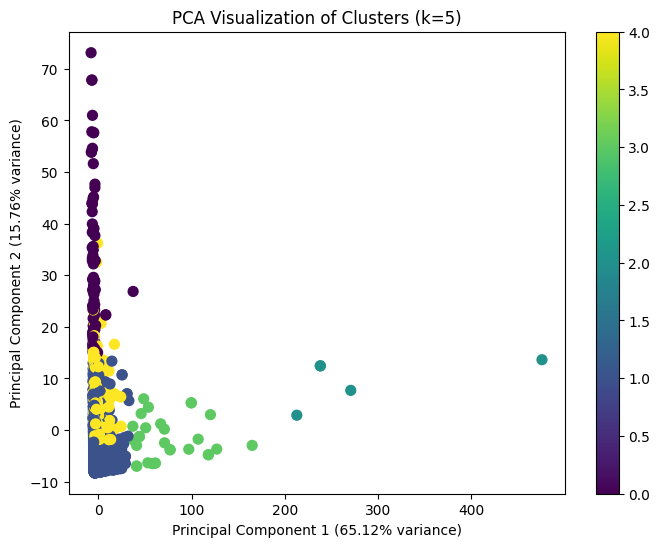

In [55]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Function to perform PCA and plot the clusters
def visualize_pca_clusters(data, k, random_state=0, n_init=50, max_iter=500):
    # Step 1: Apply KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=n_init, max_iter=max_iter)
    kmeans.fit(data)
    labels = kmeans.labels_
    
    # Step 2: Apply PCA for dimensionality reduction
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data)
    explained_variance = pca.explained_variance_ratio_
    
    # Create dynamic labels for principal components based on explained variance
    pc1_label = f'Principal Component 1 ({explained_variance[0]:.2%} variance)'
    pc2_label = f'Principal Component 2 ({explained_variance[1]:.2%} variance)'
    
    # Step 3: Visualize the clusters in 2D space
    plt.figure(figsize=(8, 6))
    plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels, cmap='viridis', s=50)
    plt.xlabel(pc1_label)
    plt.ylabel(pc2_label)
    plt.title(f'PCA Visualization of Clusters (k={k})')
    plt.colorbar()
    plt.show()

# Example usage: visualize clusters with k=5 after PCA
visualize_pca_clusters(types, k=5)



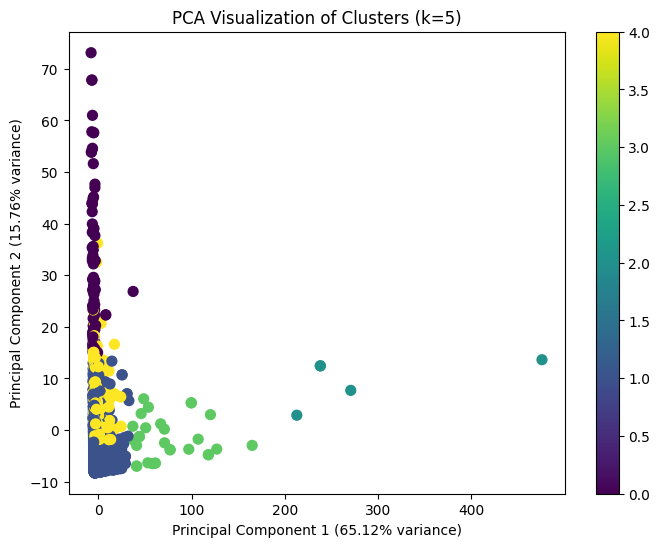

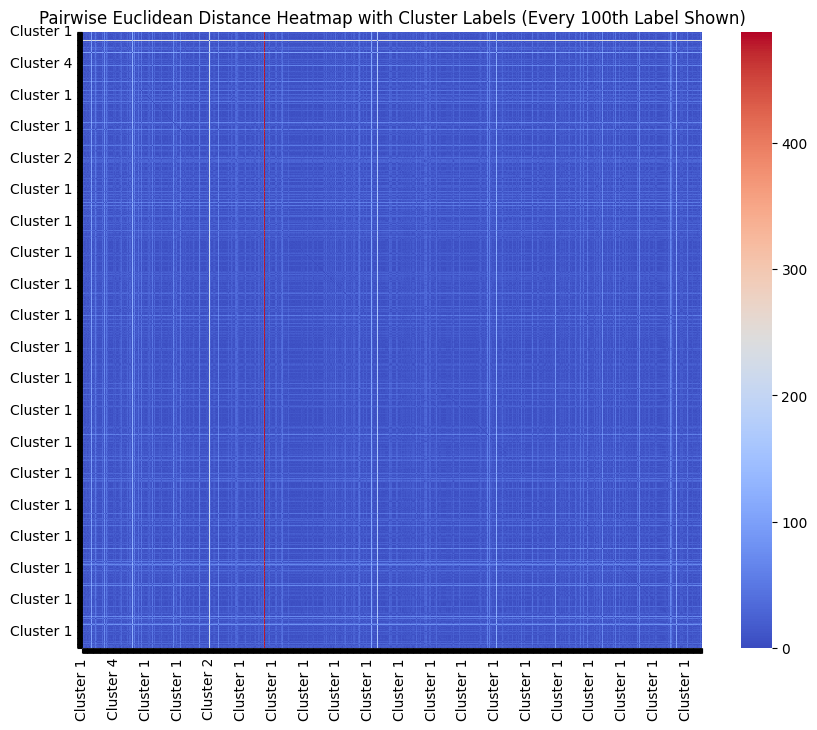

In [56]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import seaborn as sns
import numpy as np

# Function to perform PCA, plot clusters and generate heatmap of pairwise distances
def visualize_pca_clusters_with_heatmap(data, k, random_state=0, n_init=50, max_iter=500, interval=100):
    # Step 1: Apply KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=n_init, max_iter=max_iter)
    kmeans.fit(data)
    labels = kmeans.labels_
    
    # Step 2: Apply PCA for dimensionality reduction
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data)
    explained_variance = pca.explained_variance_ratio_
    
    # Create dynamic labels for principal components based on explained variance
    pc1_label = f'Principal Component 1 ({explained_variance[0]:.2%} variance)'
    pc2_label = f'Principal Component 2 ({explained_variance[1]:.2%} variance)'
    
    # Step 3: Visualize the clusters in 2D space
    plt.figure(figsize=(8, 6))
    plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels, cmap='viridis', s=50)
    plt.xlabel(pc1_label)
    plt.ylabel(pc2_label)
    plt.title(f'PCA Visualization of Clusters (k={k})')
    plt.colorbar()
    plt.show()
    
    # Step 4: Calculate pairwise Euclidean distances and plot heatmap
    distance_matrix = pairwise_distances(data, metric='euclidean')
    
    # Step 5: Create labels for x and y axis based on cluster assignment, with interval for labels
    cluster_labels = [f'Cluster {label}' if i % interval == 0 else '' for i, label in enumerate(labels)]
    
    # Plot heatmap with spaced labels
    plt.figure(figsize=(10, 8))
    sns.heatmap(distance_matrix, cmap='coolwarm', xticklabels=cluster_labels, yticklabels=cluster_labels)
    
    plt.title('Pairwise Euclidean Distance Heatmap with Cluster Labels (Every 100th Label Shown)')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.show()

# Example usage: visualize clusters with k=5 after PCA and show distance heatmap with spaced cluster labels
visualize_pca_clusters_with_heatmap(types, k=5, interval=100)



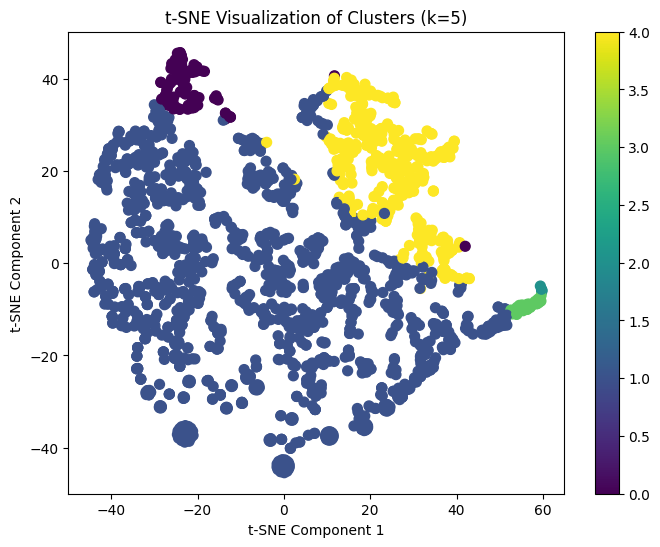

In [57]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Function to perform t-SNE and plot the clusters
def visualize_tsne_clusters(data, k, random_state=0, n_init=50, max_iter=500):
    # Step 1: Apply KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=n_init, max_iter=max_iter)
    kmeans.fit(data)
    labels = kmeans.labels_
    
    # Step 2: Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=random_state)
    data_tsne = tsne.fit_transform(data)
    
    # Step 3: Create dynamic labels for t-SNE components
    tsne_label1 = 't-SNE Component 1'
    tsne_label2 = 't-SNE Component 2'
    
    # Step 4: Visualize the clusters in 2D space
    plt.figure(figsize=(8, 6))
    plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=labels, cmap='viridis', s=50)
    plt.xlabel(tsne_label1)
    plt.ylabel(tsne_label2)
    plt.title(f't-SNE Visualization of Clusters (k={k})')
    plt.colorbar()
    plt.show()

# Example usage: visualize clusters with k=5 using t-SNE
visualize_tsne_clusters(types, k=5)



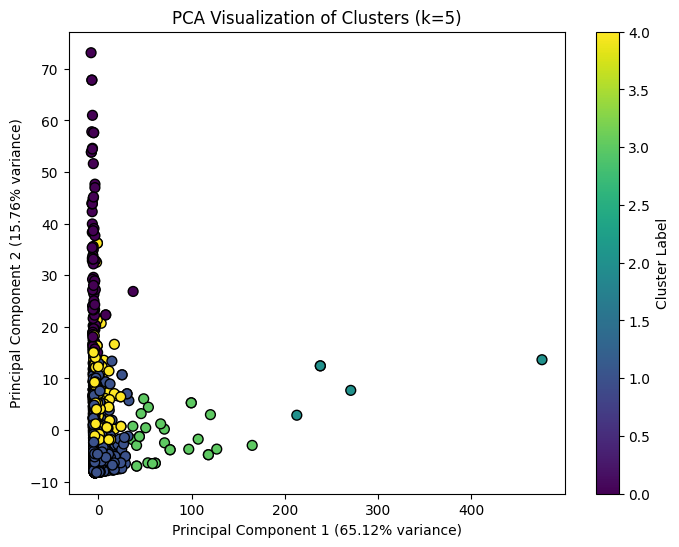

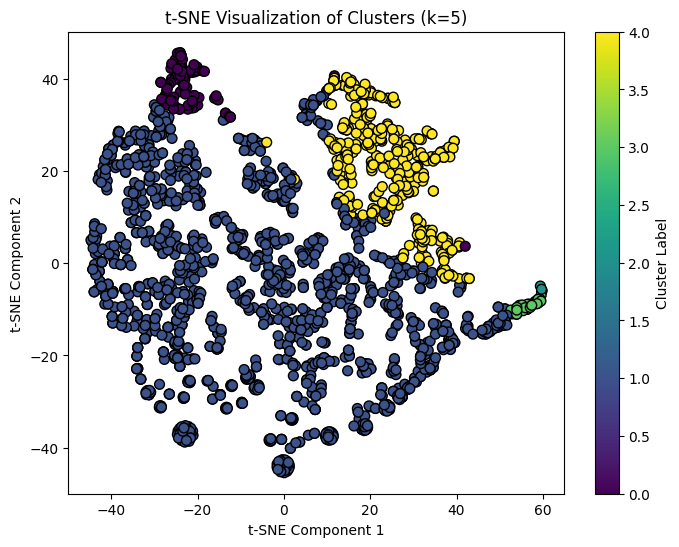

In [58]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 通用降维和可视化函数
def visualize_clusters(data, k=4, method='PCA', random_state=0, n_init=50, max_iter=500):
    """
    Visualizes clusters using a specified dimensionality reduction technique.

    Args:
        data (DataFrame): The input data for clustering.
        k (int): Number of clusters for KMeans.
        method (str): Dimensionality reduction technique ('PCA' or 't-SNE').
        random_state (int): Random seed for reproducibility.
        n_init (int): Number of initializations for KMeans.
        max_iter (int): Maximum number of iterations for KMeans.
    """
    # Step 1: Apply KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=n_init, max_iter=max_iter)
    kmeans.fit(data)
    labels = kmeans.labels_

    # Step 2: Dimensionality reduction
    if method == 'PCA':
        reducer = PCA(n_components=2)
        reduced_data = reducer.fit_transform(data)
        explained_variance = reducer.explained_variance_ratio_
        xlabel = f'Principal Component 1 ({explained_variance[0]:.2%} variance)'
        ylabel = f'Principal Component 2 ({explained_variance[1]:.2%} variance)'
    elif method == 't-SNE':
        reducer = TSNE(n_components=2, random_state=random_state)
        reduced_data = reducer.fit_transform(data)
        xlabel, ylabel = 't-SNE Component 1', 't-SNE Component 2'
    else:
        raise ValueError(f"Unknown method '{method}', choose 'PCA' or 't-SNE'")
    
    # Step 3: Visualize clusters
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', s=50, marker='o', edgecolor='k')
    plt.title(f'{method} Visualization of Clusters (k={k})')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar(label='Cluster Label')
    plt.show()

# Example usage: PCA visualization
visualize_clusters(types, k=5, method='PCA')

# Example usage: t-SNE visualization
visualize_clusters(types, k=5, method='t-SNE')




In [61]:
# 使用 get_dummies 進行廣泛天氣條件的編碼
types = pd.get_dummies(df_types[['Broad_Weather_Condition']])

# 加入 AirportCode 列
types['AirportCode'] = df_types['AirportCode']

# 按 AirportCode 進行聚合
types = types.groupby('AirportCode').sum().reset_index()

# 執行 KMeans 聚類
types['cluster'] = kmeans.labels_

# 假設 df 包含 AirportCode, LocationLat 和 LocationLng 的數據
location_data = df[['AirportCode', 'LocationLat', 'LocationLng']].drop_duplicates()

# 合併 types 和 location_data，基於 AirportCode
combined_df = types.merge(location_data, on='AirportCode', how='left')

# 顯示前幾行結果
print(combined_df.head(10))



  AirportCode  Broad_Weather_Condition_cold  Broad_Weather_Condition_foggy  \
0        K01M                             2                              0   
1        K04V                             1                              0   
2        K04W                            10                              1   
3        K06D                            13                             17   
4        K08D                            10                             12   
5        K0A9                             4                             18   
6        K0CO                             3                              1   
7        K0E0                             0                              0   
8        K0F2                             3                              0   
9        K0J4                             1                              3   

   Broad_Weather_Condition_rainy  Broad_Weather_Condition_snowy  cluster  \
0                              3                              4  

In [88]:
import folium
import pandas as pd
import numpy as np

# 设置地图中心点（以美国为例）
latitude = 38.500000
longitude = -95.665

# 创建美国地图
map_USA = folium.Map(location=[latitude, longitude], zoom_start=4)

# 定义不同 cluster 的颜色
sorted_colors = ['#5d3ebc', '#d4a100', '#006400', '#0077a8', '#ed5564']  # 紫、黄、绿、蓝、红

# 假设 'combined_df' 是包含 'LocationLat', 'LocationLng', 'City', 'State', 'cluster' 的 DataFrame
# 计算每个 cluster 出现的次数
cluster_counts = np.bincount(combined_df['cluster'])

# 根据出现次数对 cluster 排序，找到对应的 cluster 排名
cluster_ranking = np.argsort(-cluster_counts)  # 从多到少排序

# 遍历 combined_df 中的每一行，将数据点添加到地图中
for _, row in combined_df.iterrows():
    # 根据 cluster 排名选择颜色
    cluster = row['cluster']
    color_index = np.where(cluster_ranking == cluster)[0][0]  # 找到 cluster 对应的排名索引
    color = sorted_colors[color_index % len(sorted_colors)]  # 根据排名索引选择颜色
    
    # 使用 folium 创建地图标记
    folium.vector_layers.CircleMarker(
        location=[row['LocationLat'], row['LocationLng']],
        radius=5,
        tooltip=f"{row['AirportCode']}, Cluster: {row['cluster']}",  # 显示 AirportCode 和 Cluster 信息
        color=color,  # 边框颜色
        opacity=0.3,  # 边框透明度
        fill=True,
        fill_color=color,  # 填充颜色
        fill_opacity=0.4  # 填充透明度
    ).add_to(map_USA)

# 保存地图为 HTML 文件
map_USA.save('updated_map/airport_cluster_map.html')







In [89]:
# 检查 'AirportCode' 是否在 types 中
if 'AirportCode' in types.columns:
    # 如果存在，则删除 'AirportCode' 列
    types = types.drop(columns=['AirportCode'])
else:
    print("'AirportCode' not existing.")

# 检查前 30 行结果
print(types.head(30))


'AirportCode' not existing.
    Broad_Weather_Condition_cold  Broad_Weather_Condition_foggy  \
0                              2                              0   
1                              1                              0   
2                             10                              1   
3                             13                             17   
4                             10                             12   
5                              4                             18   
6                              3                              1   
7                              0                              0   
8                              3                              0   
9                              1                              3   
10                             0                              4   
11                            10                              4   
12                             2                              5   
13                             5  

In [90]:
types.groupby('cluster').mean()

,Broad_Weather_Condition_cold,Broad_Weather_Condition_foggy,Broad_Weather_Condition_rainy,Broad_Weather_Condition_snowy
cluster,,,,
0,2.859649,3.070850,3.603239,2.258435
1,159.769231,4.769231,2.538462,5.076923
2,1.220930,15.081395,37.709302,3.616279
3,481.000000,1.000000,4.000000,15.000000
4,8.353100,11.021563,3.719677,16.876011


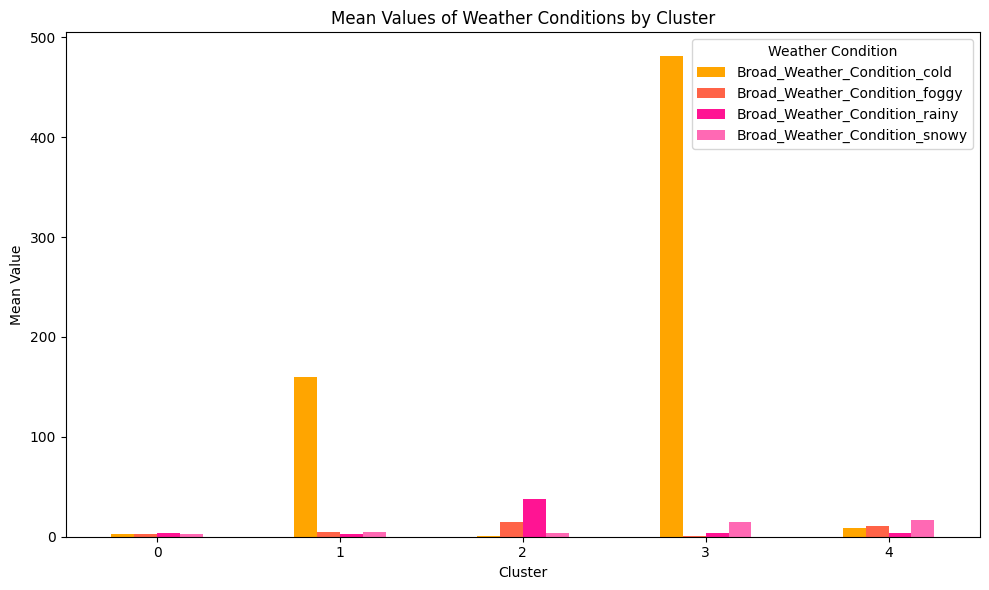

In [91]:
# 从 types 数据进行分组并计算均值
cluster_means = types.groupby('cluster').mean()

# 定义颜色方案
colors = ['#FFA500', '#FF6347', '#FF1493', '#FF69B4']  # 橙色、番茄色、粉红色、浅粉红色

# 可视化这些数据
cluster_means.plot(kind='bar', figsize=(10, 6), color=colors)
plt.title('Mean Values of Weather Conditions by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Mean Value')
plt.xticks(rotation=0)
plt.legend(title='Weather Condition')
plt.tight_layout()

# 显示图表
plt.show()

In [92]:
import folium
import pandas as pd

# 设置地图中心点（以美国为例）
latitude = 38.500000
longitude = -95.665

map_USA = folium.Map(location=[latitude, longitude], zoom_start=4)

# 假设 df 包含机场的基本信息
airports = df[['AirportCode', 'LocationLat', 'LocationLng', 'City', 'State']]

# 计算每个机场的出现次数
number_of_occurences = pd.DataFrame(airports['AirportCode'].value_counts())
number_of_occurences.reset_index(inplace=True)
number_of_occurences.columns = ['AirportCode', 'Count']

# 合并机场信息
number_of_occurences = number_of_occurences.merge(airports.drop_duplicates(), on='AirportCode')

# 假设没有聚类信息，不使用聚类颜色
default_color = 'green'  # 可以选择任何默认颜色

# 可视化 - Folium CircleMarker 的创建
occurences = folium.map.FeatureGroup()

# 计算出现次数的平均值，用于缩放圆形标记的大小
n_mean = number_of_occurences['Count'].mean()

# 遍历每个机场的纬度、经度、出现次数、城市、州信息，并添加到地图上
for lat, lng, number, city, state in zip(
    number_of_occurences['LocationLat'],
    number_of_occurences['LocationLng'],
    number_of_occurences['Count'],
    number_of_occurences['City'],
    number_of_occurences['State']
):
    occurences.add_child(
        folium.vector_layers.CircleMarker(
            [lat, lng],
            radius=number / n_mean * 3,  # 根据出现次数缩放圆的大小
            color='orange',  # 圆的边框颜色
            fill=True,
            fill_color='blue',  # 圆的填充颜色
            fill_opacity=0.6,  # 圆的透明度
            tooltip=f'{number}, {city}, {state}'  # 显示机场的城市和州
        )
    )

# 将机场出现次数图层添加到地图上
map_USA.add_child(occurences)

# 显示地图
map_USA

map_USA.save('updated_map/map_USA.html')

In [93]:
# 檢查 'number_of_occurences' DataFrame 中的可用列
print(number_of_occurences.columns)

# 如果 'cluster' 列不存在，則從已有的聚類結果中加入
if 'cluster' not in number_of_occurences.columns:
    # 檢查 'codes' DataFrame 是否有聚類信息
    if 'cluster' in codes.columns:
        # 假設 'AirportCode' 是兩個 DataFrame 共有的列，基於該列進行合併
        number_of_occurences = number_of_occurences.merge(
            codes[['AirportCode', 'cluster']], 
            on='AirportCode', 
            how='left'
        )
    else:
        print("No clustering information available in 'codes'.")

# 顯示前 10 行數據以檢查結果
print(number_of_occurences.head(10))



Index(['AirportCode', 'Count', 'LocationLat', 'LocationLng', 'City', 'State'], dtype='object')
  AirportCode  Count  LocationLat  LocationLng                     City State  \
0        KDWX    501      41.0370    -107.4998                   Savery    WY   
1        KSNC    289      41.3839     -72.5059                  Chester    CT   
2        K2C8    280      48.7838     -97.6296            Cavalier city    ND   
3        KGAF    280      48.4047     -97.3709                  Grafton    ND   
4        KCKI    227      33.7172     -79.8570                Kingstree    SC   
5        KHYI    171      29.8958     -97.8664                  Maxwell    TX   
6        KTKC    149      44.2495     -95.6119                    Tracy    MN   
7        K3TH    137      47.6000    -115.3667  Thompson Falls-West End    MT   
8        KMLP    137      47.4542    -115.6697                   Mullan    ID   
9        KLQK    133      34.8100     -82.7029                  Liberty    SC   

   cluster  


In [94]:
import numpy as np
import folium

# 指定 5 個 cluster 的顏色，按照出現次數排序
sorted_colors = ['#5d3ebc', '#d4a100', '#006400', '#0077a8', '#ed5564']  # 紫、黃、綠、藍、紅

# 創建以美國為中心的地圖
latitude, longitude = 37.0902, -95.7129  # Centered on the USA
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=4)

# 計算每個 cluster 出現的次數
cluster_counts = np.bincount(number_of_occurences['cluster'])

# 根據出現次數對 cluster 排序，找到對應的 cluster 排名
cluster_ranking = np.argsort(-cluster_counts)  # 排序為從多到少

# 在地圖上為每個 cluster 添加 marker 和 tooltip
for lat, lng, cluster, city, state in zip(
        number_of_occurences['LocationLat'], 
        number_of_occurences['LocationLng'],  
        number_of_occurences['cluster'],
        number_of_occurences['City'],
        number_of_occurences['State']):

    # 根據 cluster 排名選擇顏色
    color_index = np.where(cluster_ranking == cluster)[0][0]
    color = sorted_colors[color_index]

    # 添加 circle marker，邊框和填充顏色相同，透明度均為 0.6
    folium.vector_layers.CircleMarker(
        [lat, lng],
        radius=5,
        tooltip=f"{city}, {state} - Cluster {cluster}",
        color=color,  # 邊框顏色
        opacity=0.3,  # 邊框透明度設置為 0.3
        fill=True,
        fill_color=color,  # 填充顏色
        fill_opacity=0.4  # 填充透明度設置為 0.4
    ).add_to(map_clusters)

# 顯示地圖
map_clusters

# 保存 map_clusters 為本地 HTML 文件
map_clusters.save('updated_map/map_clusters.html')